# Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installations

In [ ]:
!pip install pyvi
!pip install torch
!pip install gensim
!pip install underthesea
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

# Fix bug

After executing this cell, you must Restart runtim (Runtime → Restart runtime)

In [ ]:
import subprocess
import sys

# !pip install numpy==1.26.4
def check_and_install_numpy(required_ver="1.26.4"):
  current_ver = np.__version__

  if current_ver != required_ver:
    print(f"Installing numpy=={required_ver}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", f"numpy=={required_ver}"])
    print("Numpy has been updated. Please restart your runtime for changes to take effect.")
  else:
    print("Numpy version is already correct.")

check_and_install_numpy()

Installing numpy==1.26.4...
Numpy has been updated. Please restart your runtime for changes to take effect.


In [ ]:
import numpy as np
print(np.__version__)

1.26.4


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from underthesea import word_tokenize

from pyvi import ViTokenizer, ViPosTagger

import gensim
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, accuracy_score

import torch

import joblib

from transformers import AutoTokenizer, AutoModel

# Dataset paths

In [ ]:
train_path = '/content/drive/MyDrive/Dataset/NLP/train.csv'
test_path = '/content/drive/MyDrive/Dataset/NLP/test.csv'
stopwords_path = '/content/drive/MyDrive/Dataset/NLP/stopwords-vi.txt'

# Preprocess dataset

In [ ]:
def load_stopwords(file_path):
  with open(file_path, 'r', encoding='utf-8-sig') as f:
    return {line.strip() for line in f if line.strip()}

def preprocess(text, stopwords):
  tokenized_text = ViTokenizer.tokenize(text)
  tokens = simple_preprocess(tokenized_text)
  tokens = [token for token in tokens if token not in stopwords]
  return " ".join(tokens)

In [ ]:
stopwords = load_stopwords(stopwords_path)

In [ ]:
train_df = pd.read_csv(train_path)
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x, stopwords))
train_df.to_csv('processed_train.csv')

In [ ]:
test_df = pd.read_csv(test_path)
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x, stopwords))
test_df.to_csv('processed_test.csv')

In [ ]:
train_path = '/content/drive/MyDrive/Dataset/NLP/processed_train.csv'
test_path = '/content/drive/MyDrive/Dataset/NLP/processed_test.csv'

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.shape, test_df.shape

((33759, 3), (50373, 3))

In [ ]:
train_df.sample(5)

,Unnamed: 0,text,label
3059,3059,đưa quốc dân ta đường mới_mẻ câu mở_đầu lời kê...,Chinh Tri Xa Hoi
26279,26279,milan tương_đối vất_vả cúp uefa gặp sochaux ph...,The thao
28796,28796,sắc_đẹp báu_vật thật may_mắn sở_hữu tuy_nhiên ...,Van hoa
1825,1825,cục quản_lý lao_động nước lao_động thương_binh...,Chinh Tri Xa Hoi
16484,16484,bắt_đầu xét_xử vụ sát_hại sv vũ_anh_tuấn phiên...,Phap luat


In [ ]:
X_train = train_df['text']
y_train = train_df['label']

X_test = test_df['text']
y_test = test_df['label']

['Chinh Tri Xa Hoi' 'Doi Song' 'Khoa hoc' 'Kinh doanh' 'Phap luat'
 'Suc khoe' 'The gioi' 'The thao' 'Van hoa' 'Vi tinh']


<Axes: xlabel='label'>

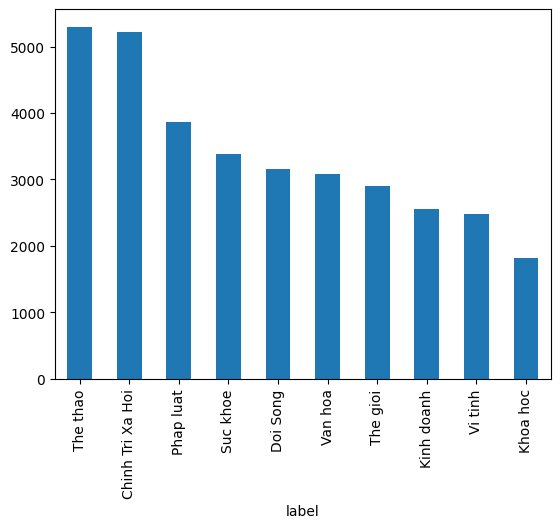

In [ ]:
print(y_train.unique())
y_train.value_counts().plot(kind='bar')

['Chinh tri Xa hoi' 'Doi song' 'Khoa hoc' 'Kinh doanh' 'Phap luat'
 'Suc khoe' 'The gioi' 'The thao' 'Van hoa' 'Vi tinh']


<Axes: xlabel='label'>

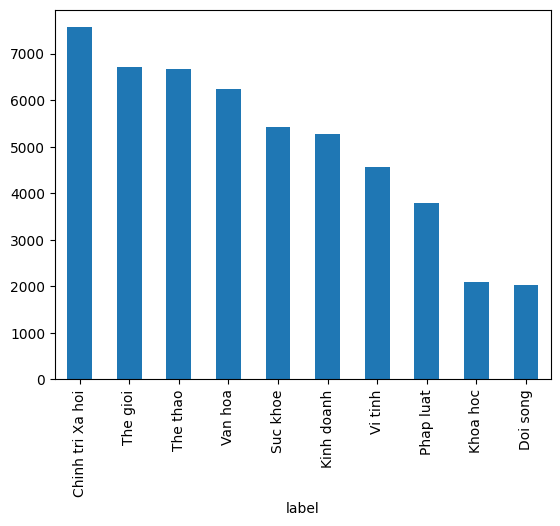

In [ ]:
print(y_test.unique())
y_test.value_counts().plot(kind='bar')

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

y_train, y_test

(array([0, 0, 0, ..., 9, 9, 9]), array([0, 0, 0, ..., 9, 9, 9]))

In [ ]:
le.classes_

array(['Chinh tri Xa hoi', 'Doi song', 'Khoa hoc', 'Kinh doanh',
       'Phap luat', 'Suc khoe', 'The gioi', 'The thao', 'Van hoa',
       'Vi tinh'], dtype=object)

# Bag of Words

## Count Vectors as features

In [ ]:
# def sparse_to_dense(sparse):
#   try:
#     return sparse.toarray()
#   except MemoryError:
#     print("Not enough memory to convert from sparse matrix to dense matrix")
#     return None

In [ ]:
def classification_pipeline(X_train, X_test, y_train, y_test):
  accuracies = {}
  classifiers = {
      "Logistic Regression": LogisticRegression(),
      "Naive Bayes": MultinomialNB(),
      "Decision Tree": DecisionTreeClassifier()
  }

  for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    accuracies[name] = acc

  return accuracies

def plot_accuracies(accuracies):
  models = list(accuracies.keys())
  acc_values = list(accuracies.values())

  plt.figure(figsize=(8, 6))
  bars = plt.bar(models, acc_values, width=0.4, color='skyblue', edgecolor='black')
  plt.xlabel('Models')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracies')
  plt.ylim(0, 1)
  plt.grid(False)

  for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
      f"{bar.get_height():.4f}", ha='center', va='bottom')

  plt.show()

## TF-IDF Vectors as features

## N-grams (Optional)

# Doc2Vec

## Using pretrain model : PhoBert

In [ ]:
# def get_pretrain_embedding(text, tokenizer, model):
#   inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
#   outputs = model(**inputs)
#   embedding = torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()
#   return embedding[0]

# def get_pretrain_embeddings(texts, tokenizer, model):
#   embeddings = []
#   for text in texts:
#     emb = get_pretrain_embedding(text, tokenizer, model)
#     embeddings.append(emb)
#   return np.array(embeddings)

In [ ]:
pho_bert = "vinai/phobert-base"
pho_bert_tokenizer = AutoTokenizer.from_pretrained(pho_bert)
pho_bert_model = AutoModel.from_pretrained(pho_bert)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

## Non-pretrain

In [ ]:
def train_doc2vec_model(texts, vector_size=300, window=5, min_count=2, epochs=5):
  documents = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(texts)]
  model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=4, epochs=1, compute_loss=True)
  model.build_vocab(documents)
  model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
  prev_loss = 0.0
  for epoch in range(epochs):
    model.train(documents, total_examples=model.corpus_count, epochs= 1)
    current_loss = model.get_latest_training_loss()
    epoch_loss = current_loss - prev_loss
    print(f"Epoch {epoch+1} / {epochs} - Loss: {epoch_loss}")
    prev_loss = current_loss
    # if epoch_loss < 0.001:
    #   print('Loss đã hội tụ, dừng huấn luyện.')
    #   break
  model.save("doc2vec_model.model")
  return model

In [ ]:
def get_doc2vec_embeddings(doc2vec_model, texts):
  embeddings = []
  for text in texts:
    emb = doc2vec_model.infer_vector(text.split())
    embeddings.append(emb)
  return np.array(embeddings)

In [ ]:
def train_nn_model(X_train, y_train, X_test, y_test, embedding_dim=300):
  num_classes = len(np.unique(y_train))
  y_train_cat = to_categorical(y_train, num_classes=num_classes)
  y_test_cat = to_categorical(y_test, num_classes=num_classes)

  model = Sequential()
  model.add(Input(shape=(embedding_dim,)))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  model.summary()

  history = model.fit(X_train, y_train_cat, epochs=30, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1)
  loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
  print(f"\n[Simple Neural Network] Test Accuracy: {accuracy:.4f}")
  model.save('nn_model.keras')

  return model, history

In [ ]:
train_doc2vec_model(X_train)

Epoch 1 / 5 - Loss: 0.0


Epoch 2 / 5 - Loss: 0.0


Epoch 3 / 5 - Loss: 0.0


Epoch 4 / 5 - Loss: 0.0
Epoch 5 / 5 - Loss: 0.0


In [ ]:
doc2vec_model = Doc2Vec.load('doc2vec_model.model')

In [ ]:
X_train_doc2vec = get_doc2vec_embeddings(doc2vec_model, X_train)
X_test_doc2vec = get_doc2vec_embeddings(doc2vec_model, X_test)

In [ ]:
X_train_doc2vec

array([[-0.04225004,  0.04030965,  0.05757864, ..., -0.10563713,
        -0.01210203,  0.0979069 ],
       [-0.0287572 ,  0.14365678,  0.00356752, ..., -0.06629287,
         0.02771445,  0.06172911],
       [ 0.00138609,  0.10053171,  0.01303431, ..., -0.03062744,
         0.06783073,  0.08547645],
       ...,
       [ 0.04650547, -0.14034522,  0.02934898, ..., -0.09530914,
        -0.0207505 , -0.05758943],
       [-0.05085791,  0.11449393,  0.015682  , ..., -0.13699326,
         0.05687543,  0.06504033],
       [-0.00563048,  0.03486069,  0.01823587, ..., -0.05653344,
         0.02710064,  0.04155014]], dtype=float32)

In [ ]:
nn_model, history = train_nn_model(X_train_doc2vec, y_train, X_test_doc2vec, y_test)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,394 (470.29 KB)

 Trainable params: 119,626 (467.29 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3880 - loss: 1.8376 - val_accuracy: 0.7932 - val_loss: 0.6805
Epoch 2/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7041 - loss: 0.9309 - val_accuracy: 0.8107 - val_loss: 0.6081
Epoch 3/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7369 - loss: 0.8324 - val_accuracy: 0.8194 - val_loss: 0.5763
Epoch 4/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7606 - loss: 0.7602 - val_accuracy: 0.8281 - val_loss: 0.5428
Epoch 5/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7695 - loss: 0.7273 - val_accuracy: 0.8288 - val_loss: 0.5377
Epoch 6/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7839 - loss: 0.6852 - val_accuracy: 0.8319 - val_loss: 0.5248
Epoch 7/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7874 - loss: 0.6664 - val_accuracy: 0.8346 - val_loss: 0.5139
Epoch 8/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7931 - lo

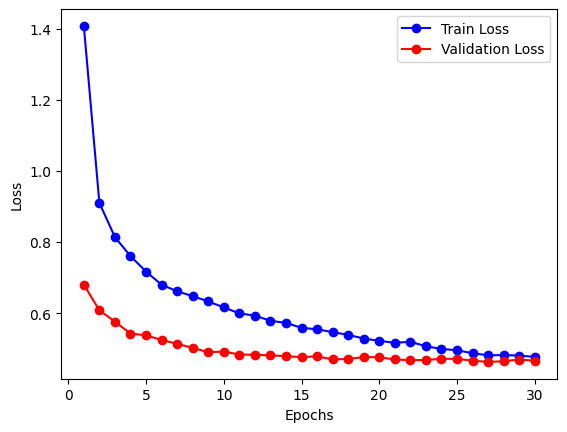

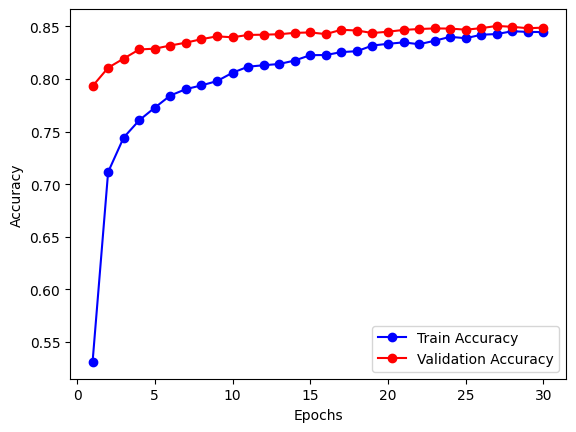

In [ ]:
def plot_history(history):
  epochs = range(1, len(history.history['loss']) + 1)

  # loss
  plt.plot(epochs, history.history['loss'], 'bo-', label='Train Loss')
  plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # accuracy
  plt.plot(epochs, history.history['accuracy'], 'bo-', label='Train Accuracy')
  plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
from tensorflow.keras.models import load_model

nn_model = load_model("nn_model.keras")
nn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 359,648 (1.37 MB)

 Trainable params: 119,626 (467.29 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 239,254 (934.59 KB)

In [ ]:
text = 'Lý do phi hành gia cần di chuyển bằng cáng khi trở về Trái Đất \n Quy định an toàn của NASA yêu cầu các phi hành gia phải nằm trên cáng do họ không thể lập tức đi lại sau khi hạ cánh và có thể bị say do chuyến bay. Ngày 18/3, hai phi hành gia NASA Sunita Williams và Butch Wilmore hạ cánh xuống đại dương trong khoang tàu của SpaceX, kết thúc hơn 9 tháng ở trong không gian thay vì vài tuần như dự kiến ban đầu. Khi khoang tàu mở ra, nhiều khả năng các phi hành gia sẽ được đưa ra ngoài và đặt lên cáng. Lý do không liên quan tới nhiệm vụ của Williams và Wilmore trên Trạm Vũ trụ Quốc tế (ISS) mà là vấn đề quy định mà mọi phi hành gia phải tuân theo, theo Live Science.'
text = preprocess(text, stopwords)
text

'lý_do phi_hành_gia di_chuyển cáng trở_về trái_đất quy_định an_toàn nasa yêu_cầu phi_hành_gia nằm cáng không_thể lập_tức đi_lại hạ_cánh có_thể say chuyến bay hai phi_hành_gia nasa sunita_williams butch wilmore hạ_cánh đại_dương khoang tàu spacex kết_thúc không_gian thay_vì vài tuần dự_kiến ban_đầu khoang tàu mở khả_năng phi_hành_gia đưa đặt cáng lý_do liên_quan nhiệm_vụ williams wilmore trạm vũ_trụ quốc_tế iss vấn_đề quy_định mọi phi_hành_gia tuân live science'

In [ ]:
emb_text = doc2vec_model.infer_vector(text.split())
emb_text = np.array(emb_text).reshape(1, -1)

In [ ]:
prediction_probabilities = nn_model.predict(emb_text)
predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]

labels_mapping = ['Chính trị xã hội', 'Đời sống', 'Khoa học', 'Kinh doanh', 'Pháp luật', 'Sức khoẻ', 'Thế giới', 'Thể thao', 'Văn hoá', 'Vi tính']

predicted_label = labels_mapping[predicted_class_index]
print("Predicted class index:", predicted_class_index)
print("Predicted class label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted class index: 2
Predicted class label: Khoa học


In [ ]:
def classify_text(text, stopwords, doc2vec, model):
  processed_text = preprocess(text, stopwords)
  embedding_vector = doc2vec.infer_vector(processed_text.split())
  reshape_vector = np.array(embedding_vector).reshape(1, -1)
  pred_probs = model.predict(reshape_vector)
  pred_idx = np.argmax(prediction_probabilities, axis=1)[0]
  labels_mapping = ['Chính trị xã hội', 'Đời sống', 'Khoa học', 'Kinh doanh', 'Pháp luật', 'Sức khoẻ', 'Thế giới', 'Thể thao', 'Văn hoá', 'Vi tính']
  predicted_label = labels_mapping[pred_idx]
  print("Predicted class index:", pred_idx)
  print("Predicted class label:", pred_idx)